# Assignment 3: Convolutional Neural Networks (CNNs)


We first import all we need. These modules help us loading dataset and implementing our deep CNNs.

In [1]:
%pip install torch torchvision matplotlib numpy IPython Torchvision 

Note: you may need to restart the kernel to use updated packages.


In [2]:
# this is used to include model diagram in this file. It is not related to the implementation
from IPython.display import Image

# torch and its modules
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Subset

# torchvision and its modules
import torchvision
import torchvision.datasets as DS
import torchvision.transforms as transforms

# for plotting
import matplotlib.pyplot as plt

# for algebric computations
import numpy as np


## Question 1: Making Dataset from CIFAR-10
To make our dataset, we first load CIFAR-10.

In [3]:
# We define the transform: this make the dataset into tensors and normalize it properly
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# let's now load CIFAR-10 train and test datasets
train_set = DS.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = test_set = DS.CIFAR10(root='./data', train=False, download=True, transform=transform)

### Play around with CIFAR-10
We may now take a look at the datast properties.

In [4]:
# Print size of the sets
print("Training set size:", len(train_set))
print("Test set size:", len(test_set))

# Check a data sample
print(train_set[0])
# print the label
print("Label:", train_set[0][1])

# print classes
print(train_set.class_to_idx)


Training set size: 50000
Test set size: 10000
(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
         [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],

        [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
         [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
         [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
         ...,
         [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
         [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
         [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],

        [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922]

To show an image, you may use the following function.

In [5]:
def imshow(img):
    # remove the impact of normalization
    img = img / 2 + 0.5
    npimg = img.numpy()

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

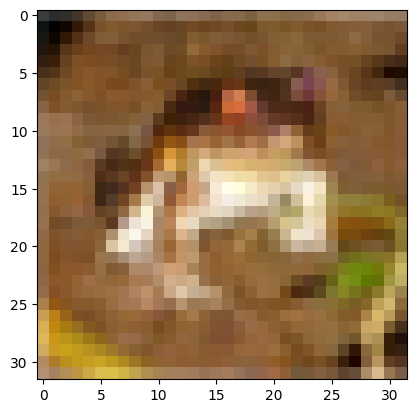

In [6]:
# use imshow() to look into a sample image
imshow(train_set[0][0])  # Gets the image tensor from the first training example

### Make Training and Test Subsets
We first write the function `class_extract` that gets a dataset and a list of classes and returns a subset of dataset that include only the data-points of that class.

In [7]:
def class_extract(cls_list, dataset):
    # initial values
    indx_set = []
    label_set = {}

    # we want later to rewrite the classes
    new_labels = {cls: i for i, cls in enumerate(cls_list)}

    # go through dataset and find points whose labels are in cls_list
    for indx, data in enumerate(dataset):
        if data[1] in cls_list:
            indx_set.append(indx)
            label_set[indx] = label_set[indx] = new_labels[data[1]]  # Maps original label to new label using new_labels dict

    # give data-points of the subset new label
    # for instance: we set now cat to class 0 and dog to class 1
    for indx in indx_set:
        dataset.targets[indx] = dataset.targets[indx] = new_labels[dataset.targets[indx]]  # Update dataset labels using new_labels mapping

    subset = Subset(dataset, indx_set)
    return subset

We may now try our implementation

In [8]:
cls_list = [train_set.class_to_idx['cat'], train_set.class_to_idx['dog']]
train_subset = class_extract(cls_list, train_set)
test_subset = class_extract(cls_list, test_set)

Now, let's check the size of this reduced dataset.

Training subset size: 10000
Test subset size: 2000


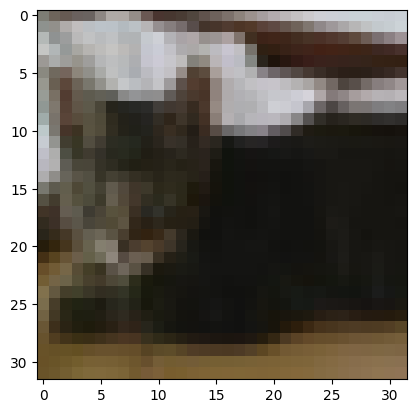

Label: 0


In [9]:
# print the size of test and train subsets
print("Training subset size:", len(train_subset))
print("Test subset size:", len(test_subset))

# you may also use imshow() to take a look at the set
imshow(train_subset[0][0])
print("Label:", train_subset[0][1])

### Load Training and Test Datasets as Mini-Batches
We now use the subsets to make our training and test datasets.

Use `DataLoader` to load the training and test datasets as sequences of mini-batches with batch size 100. Do not forget to set option `shuffle = True` when you use DataLoader.

In [10]:
batch_size = 100 
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=True)

Confirm that the number of mini-batches in iterators `train_loader` and `test_loader` matches what you expect.

In [11]:
# print the size of loaders and compare to what you expect
print("Number of training mini-batches:", len(train_loader))
print("Number of test mini-batches:", len(test_loader))

Number of training mini-batches: 100
Number of test mini-batches: 20


## Question 2: Implementing Plain CNN
The diagram of the model is given below. You may first try playing with `nn.Conv2d` and `nn.MaxPool2d` to get ready for implementation.

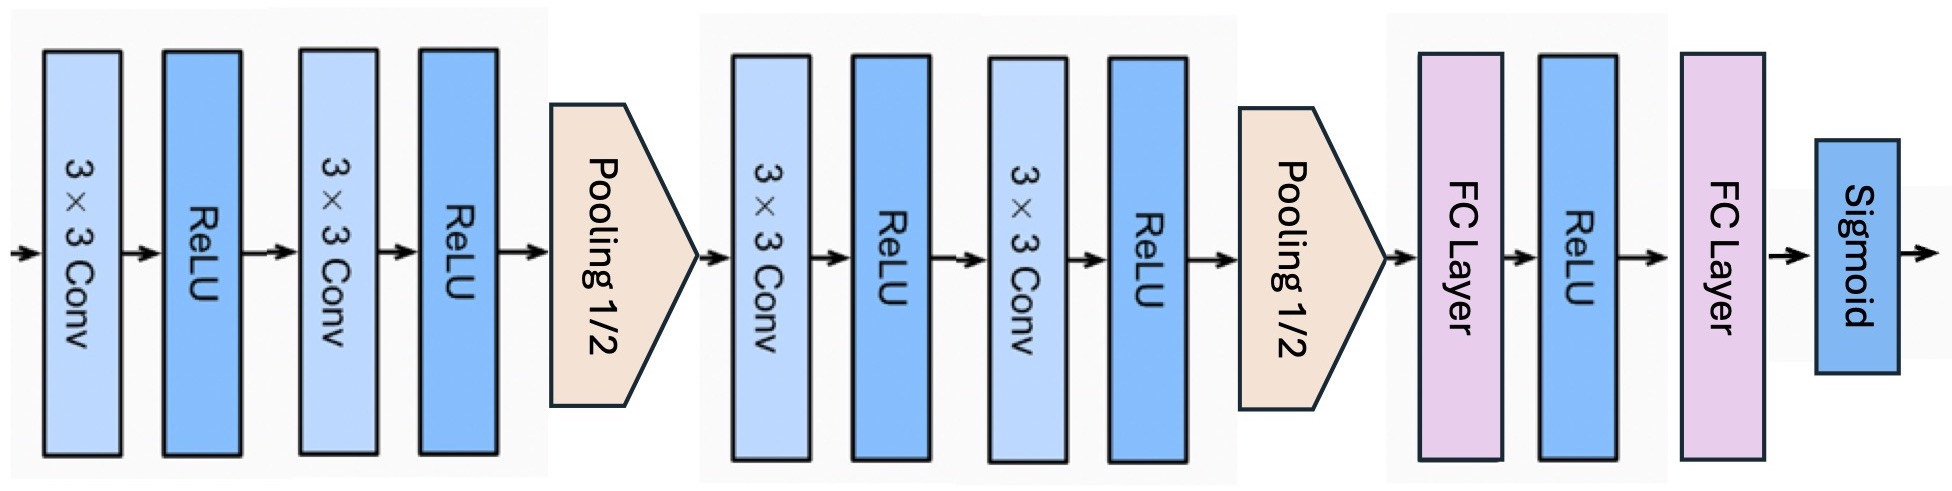

In [12]:
Image("CNN.jpg")

### Implementing the Plain CNN

In [13]:
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.conv6 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 1)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # First convolutional block
        x = self.conv1(x)
        x = self.relu(x)
        
        # Second convolutional block
        x = self.conv2(x)
        x = self.relu(x)
        
        # First pooling layer
        x = self.conv3(x)
        
        # Third convolutional block
        x = self.conv4(x)
        x = self.relu(x)
        
        # Fourth convolutional block
        x = self.conv5(x)
        x = self.relu(x)
        
        # Second pooling layer
        x = self.conv6(x)
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        
        # Final output layer
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x

### Implementing the Test Function

When implementing, we could use the variable `device` that specifies the device on which the computation is carried out. You may look at the following sample code.

In [14]:
# We may choose a GPU if we have one on our machine
if torch.backends.cuda.is_built():
  # if we have cuda
  # usually on Windows machines with GPU
  device = "cuda"
elif torch.backends.mps.is_built():
  # if we have MPS
  # usually on MAC
  device = "mps"
else:
  # if not we should use our CPU
  device = "cpu"

In [15]:
def test(model: myCNN, loss_function, device):
    
    # we first move our model to the configured device
    model = model.to(device = device)

    # we make sure we are not tracking gradient
    # gradient is used in training, we do not need it for test
    with torch.no_grad():
        risk = 0.0
        accuracy = 0.0

        # here we are only evaluating the model
        model.eval()

        # loop over test mini-batches
        for i, (images, labels) in enumerate(test_loader):
            # reshape labels to have the same form as output
            # make sure labels are of torch.float32 type
            labels = labels.float().unsqueeze(1)

            # move tensors to the configured device
            images = images.to(device = device)
            labels = labels.to(device = device)

            # forward pass
            outputs = model(images)
            loss = loss_function(outputs, labels)

            # determine the class of output from sigmoid output
            predicted = (outputs >= 0.5).float()

            # compute the fraction of correctly predicted labels
            correct_predict = (predicted == labels).float().mean()

            risk += loss.item()
            accuracy += correct_predict.item()

        # average test risk and accuracy over the whole test dataset
        test_risk = risk / len(test_loader)
        test_accuracy = accuracy / len(test_loader)

    return test_risk, test_accuracy

Use the function to test the untrained CNN via the binary cross-entropy function. 

In [16]:
# Instantiate the class
test_model = myCNN()

# test it
test_risk, test_accuracy = test_risk, test_accuracy = test(test_model, nn.BCELoss(), device)

print(test_risk, test_accuracy)

0.6936815410852433 0.49999998807907103


### Implementing Training Loop

In [17]:
def train(model, num_epochs, device):

    # we first move our model to the configured device
    model = model.to(device = device)

    # set loss to binary CE
    loss_function = nn.BCELoss()

    # Set optimizer with optimizer
    optimizer = optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Initiate the values
    train_risk = []
    test_risk = []
    test_accuracy = []


    for epoch in range(num_epochs):
        # training risk in one epoch
        risk = 0.0

        # tell pytorch that you start training
        model.train()

        # loop over training data
        for i, (images, labels) in enumerate(train_loader):

            # reshape labels to have the same form as output
            # make sure labels are of torch.float32 type
            labels = labels.float().unsqueeze(1)

            # move tensors to the configured device
            images = images.to(device = device)
            labels = labels.to(device = device)

            # forward pass
            outputs = model(images)
            loss = loss_function(outputs, labels)

            # collect the training loss
            risk += loss.item()

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # one step of gradient descent
            optimizer.step()

        # first we tell pytorch we are doing evaluation (reassure it, as we have already included it in test())
        model.eval()

        # test out model after update by the optimizer
        risk_epoch, accuracy_epoch = test(model, nn.BCELoss(), device)

        # collect losses and accuracy
        train_risk.append(risk / len(train_loader))
        test_risk.append(risk_epoch)
        test_accuracy.append(accuracy_epoch)

        # we can print a message every second epoch
        if (epoch+1) % 2 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Risk: {train_risk[-1]:.4f}, Test Risk: {test_risk[-1]:.4f}, Test Accuracy: {test_accuracy[-1]:.4f}')
            

    # plot the training and test losses
    plt.plot([i+1 for i in range(num_epochs)], train_risk, label='train')
    plt.plot([i+1 for i in range(num_epochs)], test_risk, label='test')
    plt.legend()
    plt.title('Train and Test Risk')
    plt.xlabel('Epoch')
    plt.ylabel('Risk')
    plt.show()

    # plot the test accuracy
    plt.plot([i+1 for i in range(num_epochs)], test_accuracy)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    return train_risk, test_risk, test_accuracy

Now, we can train

Epoch [2/20], Train Risk: 0.6115, Test Risk: 0.5881, Test Accuracy: 0.6830
Epoch [4/20], Train Risk: 0.5160, Test Risk: 0.5152, Test Accuracy: 0.7395
Epoch [6/20], Train Risk: 0.4417, Test Risk: 0.4713, Test Accuracy: 0.7615
Epoch [8/20], Train Risk: 0.3633, Test Risk: 0.4502, Test Accuracy: 0.7880
Epoch [10/20], Train Risk: 0.2959, Test Risk: 0.4492, Test Accuracy: 0.7965
Epoch [12/20], Train Risk: 0.2160, Test Risk: 0.5229, Test Accuracy: 0.7955
Epoch [14/20], Train Risk: 0.1363, Test Risk: 0.6172, Test Accuracy: 0.7910
Epoch [16/20], Train Risk: 0.0759, Test Risk: 0.8155, Test Accuracy: 0.7855
Epoch [18/20], Train Risk: 0.0561, Test Risk: 0.9791, Test Accuracy: 0.7905
Epoch [20/20], Train Risk: 0.0289, Test Risk: 1.3159, Test Accuracy: 0.7835


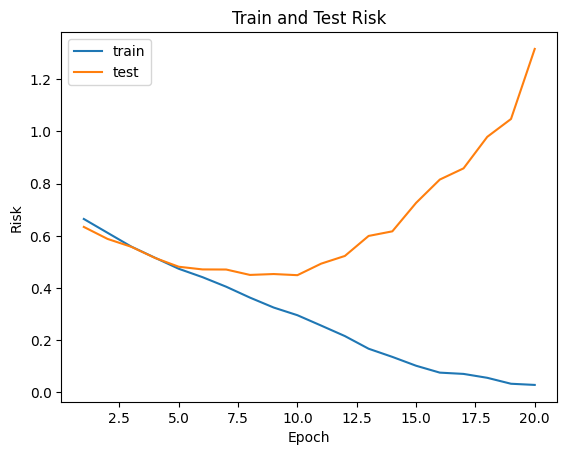

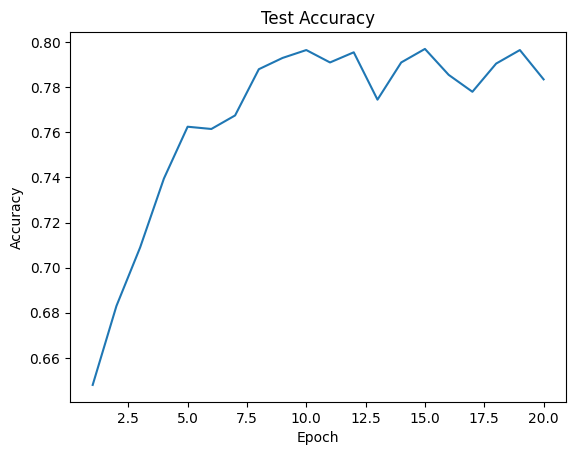

In [18]:
# Instantiate your model
model = myCNN()
num_epochs = 20

train_risk, test_risk, test_accuracy = train(model, num_epochs, device)

### Dropout and Batch Normalization
For this task you may copy class `myCNN` into this new class `myCNN_revised` and add the new blocks.

In [19]:
# myCNN_revised implementation
class myCNN_revised(nn.Module):
    def __init__(self):
        super(myCNN_revised, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout2d(p=0.4)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(64)
        self.dropout4 = nn.Dropout2d(p=0.4)
        
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.conv6 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.dropout_fc = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 1)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # First convolutional block
        x = self.dropout1(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)
        
        # Second convolutional block
        x = self.conv2(x)
        x = self.relu(x)
        
        # First pooling layer
        x = self.conv3(x)
        
        # Third convolutional block
        x = self.dropout4(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.bn4(x)
        
        # Fourth convolutional block
        x = self.conv5(x)
        x = self.relu(x)
        
        # Second pooling layer
        x = self.conv6(x)
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.dropout_fc(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bn_fc1(x)
        
        # Final output layer
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x

Repeat the training now

Epoch [2/20], Train Risk: 0.6631, Test Risk: 0.6402, Test Accuracy: 0.6275
Epoch [4/20], Train Risk: 0.6330, Test Risk: 0.6046, Test Accuracy: 0.6685
Epoch [6/20], Train Risk: 0.6108, Test Risk: 0.5772, Test Accuracy: 0.6865
Epoch [8/20], Train Risk: 0.5828, Test Risk: 0.5478, Test Accuracy: 0.7135
Epoch [10/20], Train Risk: 0.5608, Test Risk: 0.5310, Test Accuracy: 0.7260
Epoch [12/20], Train Risk: 0.5365, Test Risk: 0.5011, Test Accuracy: 0.7345
Epoch [14/20], Train Risk: 0.5173, Test Risk: 0.4859, Test Accuracy: 0.7500
Epoch [16/20], Train Risk: 0.4938, Test Risk: 0.4611, Test Accuracy: 0.7720
Epoch [18/20], Train Risk: 0.4762, Test Risk: 0.4529, Test Accuracy: 0.7810
Epoch [20/20], Train Risk: 0.4468, Test Risk: 0.4480, Test Accuracy: 0.7860


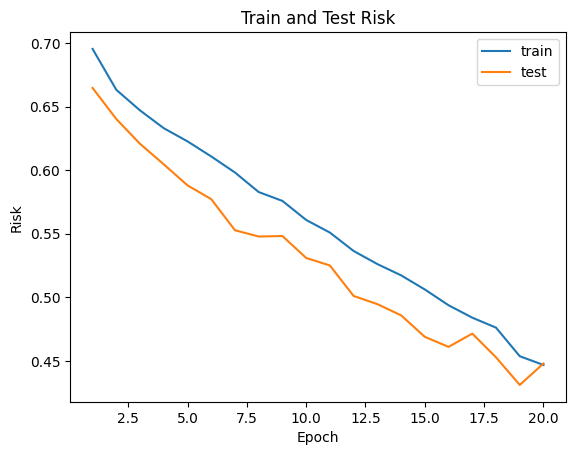

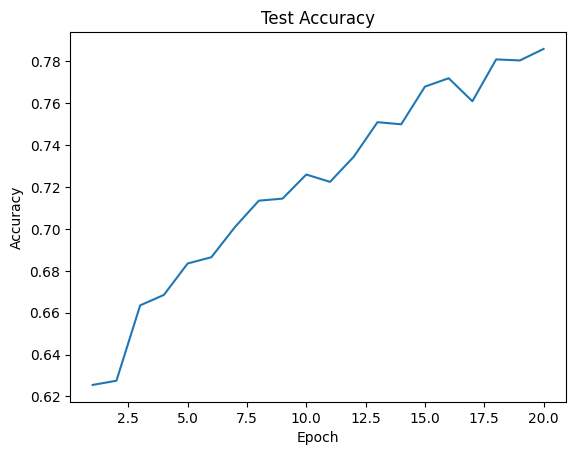

In [20]:
model = myCNN_revised()
num_epochs = 20

train_risk, test_risk, test_accuracy = train(model, num_epochs, device)

## Question 3: Implementing CNN with Skip Connection
The diagram of the model is given below.

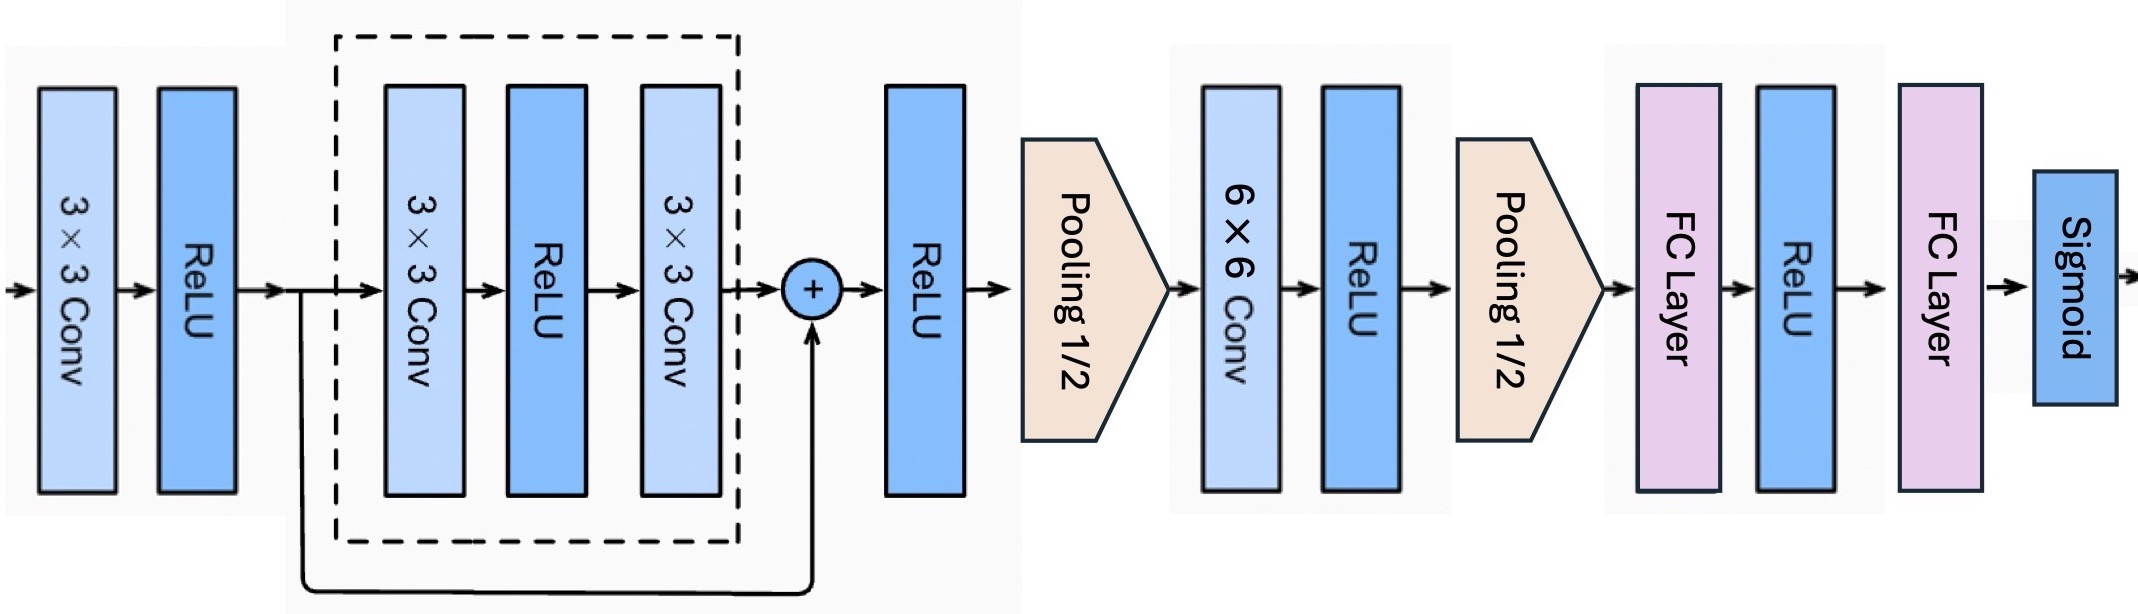

In [21]:
Image('ResNet.jpg')

In [22]:
# Instantiate the class
test_model = myCNN()

# test it
test_risk, test_accuracy = test_risk, test_accuracy = test(test_model, nn.BCELoss(), device)

print(test_risk, test_accuracy)

0.6932467967271805 0.4999999895691872


### Implement the Model
Pay attention to the skip connection. The rest is the same as the plain CNN.

In [23]:
class myResNet(nn.Module):
    def __init__(self):
        super(myResNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        
        # Residual unit with two convolutional layers
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        
        self.conv4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=6)
        self.conv6 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 1)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # First convolutional layer
        x1 = self.conv1(x)
        x1 = self.relu(x1)
        
        # Residual unit
        x2 = self.conv2(x1)
        x2 = self.relu(x2)
        x2 = self.conv3(x2)
        
        # Skip connection: add input of residual unit to its output before activation
        x2 = x2 + x1
        x2 = self.relu(x2)
        
        # Pooling layer
        x2 = self.conv4(x2)
        
        # Next convolutional layer
        x3 = self.conv5(x2)
        x3 = self.relu(x3)
        
        # Second pooling layer
        x3 = self.conv6(x3)
        
        # Flatten the tensor
        x3 = x3.view(x3.size(0), -1)
        
        # Fully connected layers
        x4 = self.fc1(x3)
        x4 = self.relu(x4)
        
        # Final output layer
        x5 = self.fc2(x4)
        x5 = self.sigmoid(x5)
        
        return x5

### Training our ResNet
We already have the training and test functions inplemented.

Epoch [2/20], Train Risk: 0.5996, Test Risk: 0.5652, Test Accuracy: 0.7080
Epoch [4/20], Train Risk: 0.5113, Test Risk: 0.5148, Test Accuracy: 0.7400
Epoch [6/20], Train Risk: 0.4505, Test Risk: 0.4773, Test Accuracy: 0.7610
Epoch [8/20], Train Risk: 0.3953, Test Risk: 0.4608, Test Accuracy: 0.7750
Epoch [10/20], Train Risk: 0.3480, Test Risk: 0.4790, Test Accuracy: 0.7790
Epoch [12/20], Train Risk: 0.2861, Test Risk: 0.4928, Test Accuracy: 0.7810
Epoch [14/20], Train Risk: 0.2143, Test Risk: 0.5584, Test Accuracy: 0.7890
Epoch [16/20], Train Risk: 0.1466, Test Risk: 0.6765, Test Accuracy: 0.7810
Epoch [18/20], Train Risk: 0.0855, Test Risk: 0.9067, Test Accuracy: 0.7830
Epoch [20/20], Train Risk: 0.0617, Test Risk: 1.1127, Test Accuracy: 0.7735


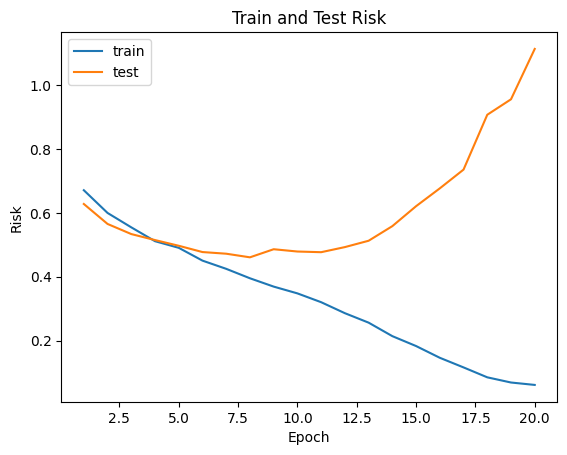

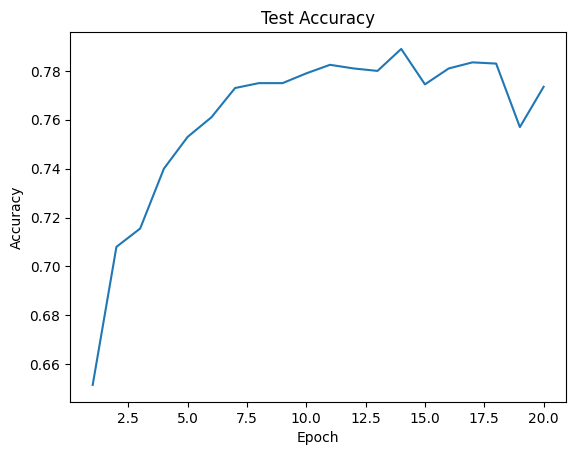

In [24]:
# Make an instant of the class
model = myResNet()
num_epochs = 20

train_risk, train_risk, test_accuracy = train(model, num_epochs, device)

### Droupout and Batch Normalization
Copy class `myResNet` into the class `myResNet_revised` and apply the modifications.

In [25]:
# myResNet_revised implementation
class myResNet_revised(nn.Module):
    def __init__(self):
        super(myResNet_revised, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout2d(p=0.4)
        
        # Residual unit with two convolutional layers
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        
        self.conv4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=6)
        self.bn5 = nn.BatchNorm2d(64)
        self.dropout5 = nn.Dropout2d(p=0.4)
        self.conv6 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.dropout7 = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(128, 1)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # First convolutional layer
        x = self.dropout1(x)
        x1 = self.conv1(x)
        x1 = self.relu(x1)
        x1 = self.bn1(x1)
        
        # Residual unit
        x2 = self.conv2(x1)
        x2 = self.relu(x2)
        x2 = self.bn2(x2)
        x2 = self.conv3(x2)
        x2 = self.relu(x2)
        x2 = self.bn3(x2)
        
        # Skip connection: add input of residual unit to its output
        x2 = x2 + x1
        x2 = self.relu(x2)
        
        # Pooling layer
        x2 = self.conv4(x2)
        
        # Next convolutional layer
        x3 = self.dropout5(x2)
        x3 = self.conv5(x3)
        x3 = self.relu(x3)
        x3 = self.bn5(x3)
        
        # Second pooling layer
        x3 = self.conv6(x3)
        
        # Flatten the tensor
        x3 = x3.view(x3.size(0), -1)
        
        # Fully connected layers
        x4 = self.dropout7(x3)
        x4 = self.fc1(x4)
        x4 = self.relu(x4)
        x4 = self.bn7(x4)
        
        # Final output layer
        x5 = self.fc2(x4)
        x5 = self.sigmoid(x5)
        
        return x5

Now, repeat the training.

Epoch [2/20], Train Risk: 0.6491, Test Risk: 0.6203, Test Accuracy: 0.6515
Epoch [4/20], Train Risk: 0.6216, Test Risk: 0.5822, Test Accuracy: 0.6855
Epoch [6/20], Train Risk: 0.5857, Test Risk: 0.5483, Test Accuracy: 0.7075
Epoch [8/20], Train Risk: 0.5557, Test Risk: 0.5119, Test Accuracy: 0.7415
Epoch [10/20], Train Risk: 0.5239, Test Risk: 0.4917, Test Accuracy: 0.7570
Epoch [12/20], Train Risk: 0.5060, Test Risk: 0.4652, Test Accuracy: 0.7655
Epoch [14/20], Train Risk: 0.4733, Test Risk: 0.4511, Test Accuracy: 0.7805
Epoch [16/20], Train Risk: 0.4578, Test Risk: 0.4426, Test Accuracy: 0.7775
Epoch [18/20], Train Risk: 0.4303, Test Risk: 0.4386, Test Accuracy: 0.7870
Epoch [20/20], Train Risk: 0.4253, Test Risk: 0.4316, Test Accuracy: 0.7985


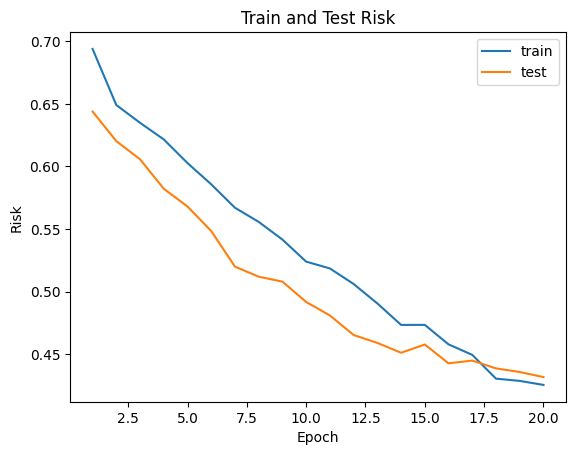

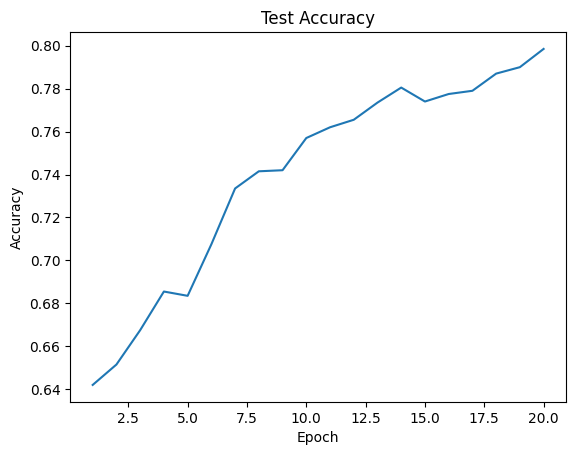

In [26]:
# Make an instant
model = myResNet_revised()
num_epochs = 20

train_risk, train_risk, test_accuracy =  train(model, num_epochs, device)

### ResNet with Only Batch Normalization
You may simply remove the dropouts, and try again training

In [27]:
class myResNet_onlyBN(nn.Module):
    def __init__(self):
        super(myResNet_onlyBN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        
        # Residual unit with two convolutional layers
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        
        self.conv4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=6)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 1)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # First convolutional layer
        x1 = self.conv1(x)
        x1 = self.relu(self.bn1(x1))
        
        # Residual unit
        x2 = self.conv2(x1)
        x2 = self.relu(self.bn2(x2))
        x2 = self.conv3(x2)
        x2 = self.bn3(x2)
        
        # Skip connection: add input of residual unit to its output before activation
        x2 = x2 + x1
        x2 = self.relu(x2)
        
        # Pooling layer
        x2 = self.conv4(x2)
        
        # Next convolutional layer
        x3 = self.conv5(x2)
        x3 = self.relu(self.bn5(x3))
        
        # Second pooling layer
        x3 = self.conv6(x3)
        
        # Flatten the tensor
        x3 = x3.view(x3.size(0), -1)
        
        # Fully connected layers
        x4 = self.fc1(x3)
        x4 = self.relu(self.bn7(x4))
        
        # Final output layer
        x5 = self.fc2(x4)
        x5 = self.sigmoid(x5)
        
        return x5

Now repeat training

Epoch [2/20], Train Risk: 0.4969, Test Risk: 0.5091, Test Accuracy: 0.7510
Epoch [4/20], Train Risk: 0.3651, Test Risk: 0.4677, Test Accuracy: 0.7840
Epoch [6/20], Train Risk: 0.2142, Test Risk: 0.7511, Test Accuracy: 0.7225
Epoch [8/20], Train Risk: 0.0909, Test Risk: 0.6808, Test Accuracy: 0.7790
Epoch [10/20], Train Risk: 0.0309, Test Risk: 0.9544, Test Accuracy: 0.7410
Epoch [12/20], Train Risk: 0.0671, Test Risk: 1.1033, Test Accuracy: 0.7380
Epoch [14/20], Train Risk: 0.0184, Test Risk: 0.8154, Test Accuracy: 0.7780
Epoch [16/20], Train Risk: 0.0047, Test Risk: 0.8859, Test Accuracy: 0.7905
Epoch [18/20], Train Risk: 0.0010, Test Risk: 0.9222, Test Accuracy: 0.7875
Epoch [20/20], Train Risk: 0.0008, Test Risk: 0.9530, Test Accuracy: 0.7885


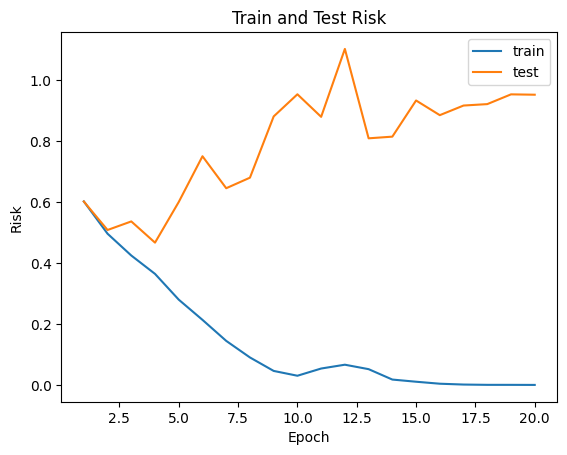

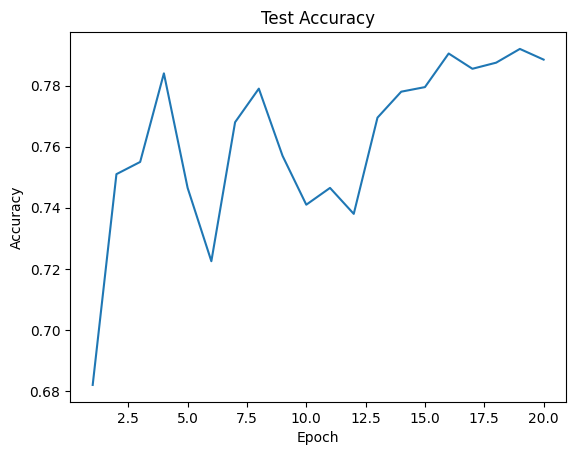

In [28]:
# Make an instant
model = myResNet_onlyBN()
num_epochs = 20

train_risk, train_risk, test_accuracy =  train(model, num_epochs, device)